<center><img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="30%" /></center>

<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Aprendizaje Automático </h1>

<H3 align='center'> Tarea/Taller 1 </H3>
<hr style="height:2px;border:none"/>

**Integrantes**


*   Domingo Benoit
*   Tomás Berríos



**Temas**  

* Clasificadores Discriminativos Clásicos
* Clasificadores Generativos Clásicos
* Regresión Lineal y Regularización 
* Selección de Características (parcial, seguiremos en T2)
* Reducción de Dimensionalidad


<hr style="height:2px;border:none"/>


#Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

import random

from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB 

from sklearn.metrics import accuracy_score

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

from sklearn.utils import resample

%matplotlib notebook

plt.style.use('seaborn-colorblind')

#Dataset

Definimos una funciona lineal y creamos el dataset sintetico

In [2]:
f = lambda x, y, z, p, q, r: 400*x + 30*y + 0.5*z + 600*p + 4*q + 0.002*r 
f = np.vectorize(f)
data = np.random.rand(80, 6)
y = f(data[:, 0], data[:, 1], data[:, 2], data[:, 3], data[:, 4], data[:, 5])
toy_dataset = pd.DataFrame(data = np.c_[data, y], columns=['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'y'])

In [3]:
min = np.min(toy_dataset['y'])
max = np.max(toy_dataset['y'])
inter = (max - min)/2
print(min, max, inter)

64.25076975377802 957.7175016685081 446.73336595736504


In [4]:
toy_dataset.loc[toy_dataset['y'] < min + inter, 'y'] = 0
toy_dataset.loc[toy_dataset['y'] >= min + inter, 'y'] = 1
toy_dataset['y'] = toy_dataset['y'].astype("int32")
n_examples = 20
n_examples

20

In [5]:
new_df_0 = resample(toy_dataset[toy_dataset['y'] == 0], 
                    replace=False,     # sample with replacement
                    n_samples=n_examples,    # to match majority class
                    random_state=123)
new_df_1 = resample(toy_dataset[toy_dataset['y'] == 1], 
                    replace=False,     # sample with replacement
                    n_samples=n_examples,    # to match majority class
                    random_state=123)

In [6]:
new_df = pd.concat([new_df_0, new_df_1])
new_df.head()

,v1,v2,v3,v4,v5,v6,y
18,0.399228,0.634284,0.857161,0.389751,0.109655,0.772420,0
23,0.436680,0.175726,0.559096,0.269578,0.194785,0.299835,0
52,0.019260,0.443003,0.359547,0.099044,0.058803,0.826090,0
78,0.212561,0.123413,0.585568,0.653257,0.532011,0.546771,0
36,0.552527,0.476581,0.591708,0.197081,0.100119,0.521183,0


In [7]:
data = np.random.rand(300, 6)
y = f(data[:, 0], data[:, 1], data[:, 2], data[:, 3], data[:, 4], data[:, 5])
test_toy_df = pd.DataFrame(data = np.c_[data, y], columns=['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'y'])
test_toy_df.loc[test_toy_df['y'] < min + inter, 'y'] = 0
test_toy_df.loc[test_toy_df['y'] >= min + inter, 'y'] = 1
test_toy_df['y'] = test_toy_df['y'].astype("int32")
n_examples = 10
new_df_0 = resample(toy_dataset[toy_dataset['y'] == 0], 
                    replace=False,     # sample with replacement
                    n_samples=n_examples,    # to match majority class
                    random_state=123)
new_df_1 = resample(toy_dataset[toy_dataset['y'] == 1], 
                    replace=False,     # sample with replacement
                    n_samples=n_examples,    # to match majority class
                    random_state=123)
test_df = pd.concat([new_df_0, new_df_1])

###Downsampling
Generamos desbalance en el dataset

In [8]:
p_imb = 0.0
n_iter = 6
df_class_0 = []
df_class_1 = []
apriors_0 = []
apriors_1 = []
for _ in range(0, n_iter):
  n_reduce = int(n_examples * p_imb)
  class_0_i = resample(new_df[new_df['y'] == 0], replace=False, n_samples=n_examples - n_reduce, random_state=123)
  class_1_i = resample(new_df[new_df['y'] == 1], replace=False, n_samples=n_examples - n_reduce, random_state=123)
  n_total = n_examples + n_examples - n_reduce
  apriors_0.append([n_examples/n_total, (n_examples - n_reduce)/n_total])
  df_class_0.append(pd.concat([new_df[new_df['y'] == 0], class_1_i]))
  apriors_1.append([(n_examples - n_reduce)/n_total, n_examples/n_total])
  df_class_1.append(pd.concat([class_0_i, new_df[new_df['y'] == 1]]))
  p_imb += 0.1

#Training
Entrenamos los modelos y observamos el desempeño en las metricas

In [12]:
cv_class_0_score_LR = []
cv_class_1_score_LR = []
cv_class_0_score_NB = []
cv_class_1_score_NB = []

acc_class_0_score_LR = []
acc_class_1_score_LR = []
acc_class_0_score_NB = []
acc_class_1_score_NB = []

x_test = test_df[['v1', 'v2', 'v3', 'v4', 'v5', 'v5']]
y_test = test_df['y']

steps = [float(i*0.1) for i in range(0, n_iter)]

roc = False

if roc:
  fig, ax1 = plt.subplots(figsize=(18,5),nrows=1)
  fig, ax2 = plt.subplots(figsize=(18,5),nrows=1)

for i in range(0, n_iter):

  lr = LogisticRegression(max_iter = 1000)
  nb = GaussianNB(priors= apriors_0[i])
  x_train = df_class_0[i][['v1', 'v2', 'v3', 'v4', 'v5', 'v5']]
  y_train = df_class_0[i]['y']

  cv_scores = cross_val_score(lr, x_train, y_train, cv = 5)
  cv_class_0_score_LR.append(np.mean(cv_scores))
  cv_scores = cross_val_score(nb, x_train, y_train, cv = 5)
  cv_class_0_score_NB.append(np.mean(cv_scores))

  lr.fit(x_train, y_train)
  y_pred = lr.predict(x_test)
  print("Porcentaje de desbalanceo LR: %",steps[i])
  print(classification_report(y_test, y_pred))
  acc_class_0_score_LR.append(accuracy_score(y_test, y_pred))
  if roc:
    fpr_binary, tpr_binary, thresholds_binary = roc_curve(y_test, y_pred)
    ax2.plot(fpr_binary, tpr_binary, label=i)
    precision_binary, recall_binary, thrs_binary = precision_recall_curve(y_test, y_pred)
    ax1.plot(recall_binary, precision_binary, label=i)
  

  nb.fit(x_train, y_train)
  y_pred = nb.predict(x_test)
  print("Porcentaje de desbalanceo NB: %",steps[i])
  print(classification_report(y_test, y_pred))
  acc_class_0_score_NB.append(accuracy_score(y_test, y_pred))
  if roc:
    fpr_binary, tpr_binary, thresholds_binary = roc_curve(y_test, y_pred)
    ax2.plot(fpr_binary, tpr_binary)
    precision_binary, recall_binary, thrs_binary = precision_recall_curve(y_test, y_pred)
    ax1.plot(recall_binary, precision_binary)
  

  lr = LogisticRegression(max_iter = 1000)
  nb = GaussianNB(priors= apriors_1[i])
  x_train = df_class_1[i][['v1', 'v2', 'v3', 'v4', 'v5', 'v5']]
  y_train = df_class_1[i]['y']

  cv_scores = cross_val_score(lr, x_train, y_train, cv = 5)
  cv_class_1_score_LR.append(np.mean(cv_scores))
  cv_scores = cross_val_score(nb, x_train, y_train, cv = 5)
  cv_class_1_score_NB.append(np.mean(cv_scores))

  lr.fit(x_train, y_train)
  y_pred = lr.predict(x_test)
  acc_class_1_score_LR.append(accuracy_score(y_test, y_pred))

  nb.fit(x_train, y_train)
  y_pred = nb.predict(x_test)
  acc_class_1_score_NB.append(accuracy_score(y_test, y_pred))


if roc:
  plt.show()

Porcentaje de desbalanceo LR: % 0.0
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        10
           1       1.00      0.50      0.67        10

    accuracy                           0.75        20
   macro avg       0.83      0.75      0.73        20
weighted avg       0.83      0.75      0.73        20

Porcentaje de desbalanceo NB: % 0.0
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.90      0.90      0.90        10

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20

Porcentaje de desbalanceo LR: % 0.1
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        10
           1       1.00      0.50      0.67        10

    accuracy                           0.75        20
   macro avg       0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Curvas PR y ROC 

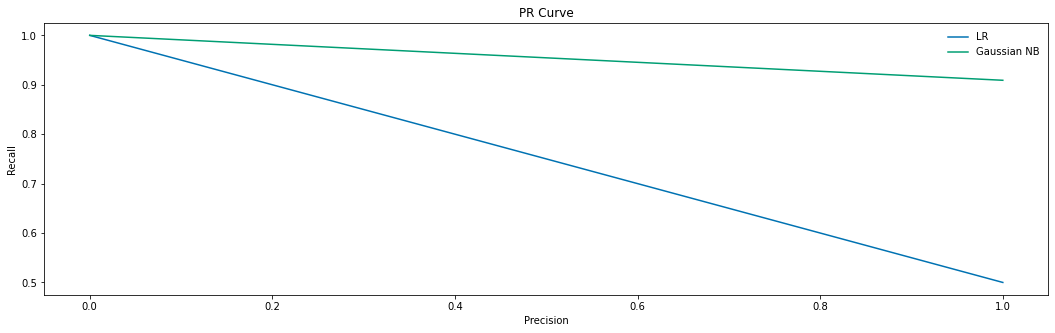

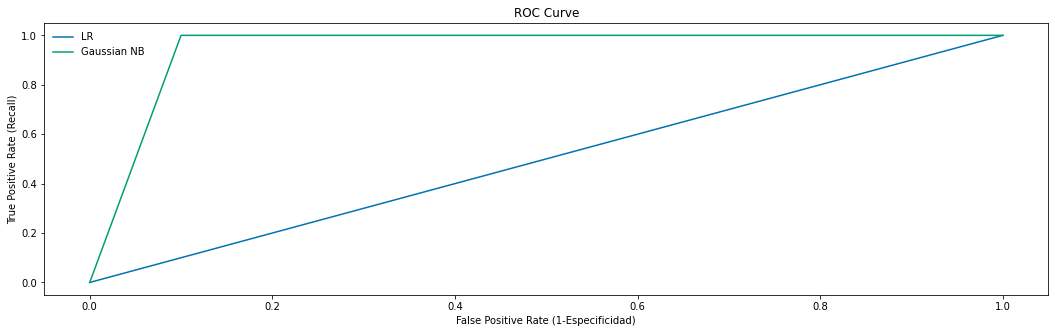

In [13]:
fig, ax1 = plt.subplots(figsize=(18,5),nrows=1)
fig, ax2 = plt.subplots(figsize=(18,5),nrows=1)

i = 5

lr = LogisticRegression(max_iter = 1000)
nb = GaussianNB(priors= apriors_0[i])
x_train = df_class_0[i][['v1', 'v2', 'v3', 'v4', 'v5', 'v5']]
y_train = df_class_0[i]['y']

lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

fpr_binary, tpr_binary, thresholds_binary = roc_curve(y_test, y_pred)
ax2.plot(fpr_binary, tpr_binary)
precision_binary, recall_binary, thrs_binary = precision_recall_curve(y_test, y_pred)
ax1.plot(recall_binary, precision_binary)

nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)

fpr_binary, tpr_binary, thresholds_binary = roc_curve(y_test, y_pred)
ax2.plot(fpr_binary, tpr_binary)
precision_binary, recall_binary, thrs_binary = precision_recall_curve(y_test, y_pred)
ax1.plot(recall_binary, precision_binary)

ax2.set_title("ROC Curve")
ax2.set_xlabel("False Positive Rate (1-Especificidad)")
ax2.set_ylabel("True Positive Rate (Recall)")
ax2.legend(['LR','Gaussian NB'],loc=0,frameon=False)
ax1.set_title("PR Curve")
ax1.set_xlabel("Precision")
ax1.set_ylabel("Recall")
ax1.legend(['LR','Gaussian NB'],loc=0,frameon=False)

plt.show()

In [ ]:
mean_CV_LR = (np.array(cv_class_1_score_LR) + np.array(cv_class_0_score_LR))/2
mean_CV_NB = (np.array(cv_class_1_score_NB) + np.array(cv_class_0_score_NB))/2
mean_acc_LR = (np.array(acc_class_1_score_LR) + np.array(acc_class_0_score_LR))/2
mean_acc_NB = (np.array(acc_class_1_score_NB) + np.array(acc_class_0_score_NB))/2

#Plotting
Gráficos puntaje CV y accuracy según el desbalance.

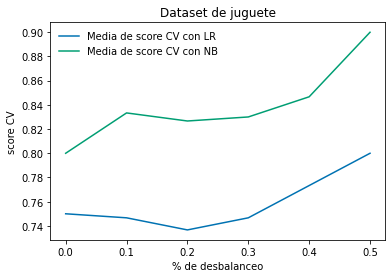

In [ ]:
plt.figure()
steps = [float(i*0.1) for i in range(0, n_iter)]
plt.plot(steps, mean_CV_LR)
plt.plot(steps, mean_CV_NB)

plt.xlabel('% de desbalanceo', fontsize=10)
plt.ylabel('score CV', fontsize=10)
plt.title('Dataset de juguete', fontsize=12)
plt.legend(['Media de score CV con LR','Media de score CV con NB'],loc=0,frameon=False)

plt.show()

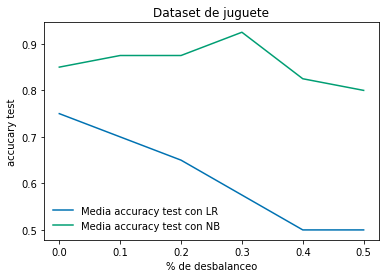

In [ ]:
plt.figure()
steps = [float(i*0.1) for i in range(0, n_iter)]
plt.plot(steps, mean_acc_LR)
plt.plot(steps, mean_acc_NB)

plt.xlabel('% de desbalanceo', fontsize=10)
plt.ylabel('accucary test', fontsize=10)
plt.title('Dataset de juguete', fontsize=12)
plt.legend(['Media accuracy test con LR','Media accuracy test con NB'],loc=0,frameon=False)

plt.show()